In [1]:
import random
import gym
import numpy as np
import sys
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# sys.path.append('sunblaze_envs')
# import sunblaze_envs

Using TensorFlow backend.
/home/dima/UCU/ReinforcementLearning/Repos/ReinforcementLearning/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dima/UCU/ReinforcementLearning/Repos/ReinforcementLearning/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dima/UCU/ReinforcementLearning/Repos/ReinforcementLearning/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be underst

In [2]:
GAMMA = 1
LEARNING_RATE = 0.001

MEMORY_SIZE = 50000
BATCH_SIZE = 32

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995

In [3]:
class Dqn:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.model = Sequential()
        self.model.add(Dense(24, input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(24, activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
            q_values = self.model.predict(state)
            q_values[0][action] = q_update
            self.model.fit(state, q_values, verbose=0)
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)
        

def train(env_name, score=199, training_episodes=10000000):
#     env = sunblaze_envs.make(env_name)
    env = gym.make(env_name)
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn = Dqn(observation_space, action_space)
    scores = []
    all_scores = []
    for i in range(1,training_episodes):
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        step = 0
        while True:
            step += 1
            action = dqn.act(state)
            state_next, reward, terminal, info = env.step(action)
            reward = reward if not terminal else -reward
            state_next = np.reshape(state_next, [1, observation_space])
            dqn.remember(state, action, reward, state_next, terminal)
            state = state_next
            if terminal:
                print("Run: " + str(i) + ", exploration: " + str(dqn.exploration_rate) + ", score: " + str(step))
                scores.append(step)
                all_scores.append(step)
                break
            dqn.experience_replay()
        if (i % 100 == 0):
            avg = np.array(scores).mean()
            print("===============")
            print("Episodes: " + str(i) + ", mean 100 episodes reward: " + str(avg))
            print("===============")
            scores = []
            if avg >= score:
                break
            
    plt.plot(all_scores)
    plt.ylabel('Reward')
    plt.show()
    return dqn

def play(dqn, env_name):
    env = gym.make(env_name)
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    step = 0
    while True:
        step += 1
        env.render()
        action = dqn.act(state)
        state_next, reward, terminal, info = env.step(action)
        reward = reward if not terminal else -reward
        state_next = np.reshape(state_next, [1, observation_space])
        state = state_next
        if terminal:
            print("Score: " + str(step))
            break





Run: 1, exploration: 1.0, score: 20


Run: 2, exploration: 0.960693043575437, score: 20
Run: 3, exploration: 0.8433051360508336, score: 27
Run: 4, exploration: 0.810157377815473, score: 9
Run: 5, exploration: 0.7402609576967045, score: 19
Run: 6, exploration: 0.6866430931872001, score: 16
Run: 7, exploration: 0.6180388156137953, score: 22
Run: 8, exploration: 0.5507399854171277, score: 24
Run: 9, exploration: 0.5082950737585841, score: 17
Run: 10, exploration: 0.47862223409330756, score: 13
Run: 11, exploration: 0.3507711574848344, score: 63
Run: 12, exploration: 0.3079101286968243, score: 27
Run: 13, exploration: 0.1346580429260134, score: 166
Run: 14, exploration: 0.1085487359239089, score: 44
Run: 15, exploration: 0.08533607153708872, score: 49
Run: 16, exploration: 0.052477299559006776, score: 98
Run: 17, exploration: 0.032595988006089364, score: 96
Run: 18, exploration: 0.029634846598205186, score: 20
Run: 19, exploration: 0.023065173234186005, score: 51
Run: 20, exploration: 

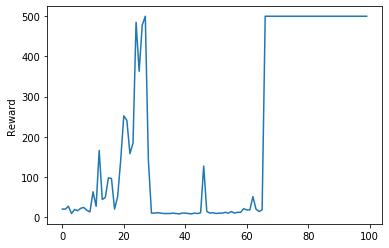

In [4]:
# dqn = train('SunblazeCartPole-v0')
env = "CartPole-v1"
dqn = train(env)

In [5]:
play(dqn, env)

Score: 500
